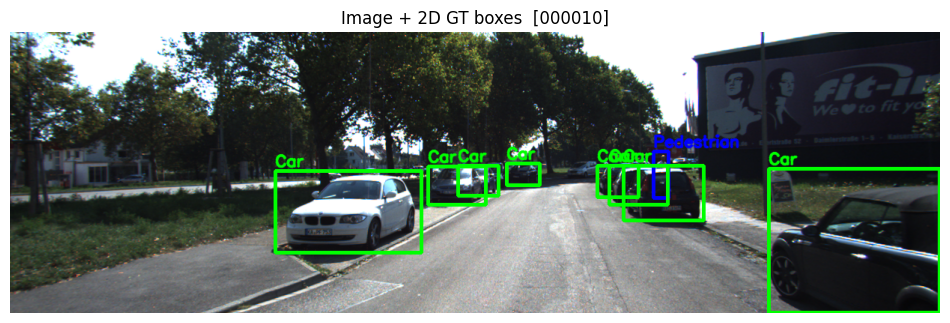

In [41]:
# ========== 공통 설정/유틸 + 원본 이미지 & 2D 라벨 ==========
import os, glob, numpy as np, cv2, matplotlib.pyplot as plt

DATA_ROOT = "/home/jinjinjara1022/AutonomousDriving/datasets/kitti_object"
SID = "000010"  # 원하는 프레임 (예: "004613")

def read_calib(path):
    D={}
    with open(path) as f:
        for ln in f:
            if ":" not in ln: 
                continue
            k,v = ln.split(":",1); a = np.fromstring(v, sep=" "); k = k.strip()
            if k in ("P2","P0","P1","P3"): D[k] = a.reshape(3,4)
            elif k in ("R0_rect","R_rect_00"): D["R0_rect"] = a.reshape(3,3)
            elif k in ("Tr_velo_to_cam","Tr_velo_cam"): D["Tr_velo_to_cam"] = a.reshape(3,4)
    assert all(k in D for k in ("P2","R0_rect","Tr_velo_to_cam")), "calib 부족"
    return D

def read_labels(path):
    objs=[]
    with open(path) as f:
        for ln in f:
            a = ln.split()
            if not a or a[0].lower()=="dontcare": 
                continue
            h,w,l = map(float, a[8:11])
            x,y,z = map(float, a[11:14])
            ry = float(a[14])
            l2,t2,r2,b2 = map(float, a[4:8])
            objs.append({"type":a[0], "bbox":[l2,t2,r2,b2], "dims":[h,w,l], "loc":[x,y,z], "ry":ry})
    return objs

def load_velo(path):
    return np.fromfile(path, dtype=np.float32).reshape(-1,4)  # (x,y,z,intensity)

def velo_to_cam_rect(pts_xyz, cal):
    N = pts_xyz.shape[0]
    pts_h = np.hstack([pts_xyz, np.ones((N,1))])
    cam = (cal["Tr_velo_to_cam"] @ pts_h.T)
    rect = (cal["R0_rect"] @ cam).T  # (x_right, y_down, z_forward)
    return rect

def project_velo_to_img(pts_xyz, cal):
    N = pts_xyz.shape[0]
    pts_h = np.hstack([pts_xyz, np.ones((N,1))])
    cam  = (cal["Tr_velo_to_cam"] @ pts_h.T)
    rect = (cal["R0_rect"] @ cam)             # 3xN
    Z    = rect[2,:]
    valid = Z > 0
    rect = rect[:,valid]; Z = Z[valid]
    rect_h = np.vstack([rect, np.ones((1,rect.shape[1]))])
    uvw = cal["P2"] @ rect_h
    u = (uvw[0,:] / uvw[2,:]).astype(int)
    v = (uvw[1,:] / uvw[2,:]).astype(int)
    return np.vstack([u,v,Z]).T, valid.nonzero()[0]

# --- 이미지 + 2D 라벨
img_path = os.path.join(DATA_ROOT,"training","image_2",f"{SID}.png")
lab_path = os.path.join(DATA_ROOT,"training","label_2",f"{SID}.txt")
img  = cv2.imread(img_path);  assert img is not None, img_path
objs = read_labels(lab_path); assert objs, "라벨 없음"

# 두껍고 선명하게(진한 색)
color_map = {"Car":(0,255,0), "Pedestrian":(255,0,0), "Cyclist":(0,200,255)}
for o in objs:
    l,t,r,b = map(int,o["bbox"])
    col = color_map.get(o["type"], (0,140,255))  # 기본: 주황
    cv2.rectangle(img,(l,t),(r,b),col,3)         # ← 굵기 3
    cv2.putText(img, o["type"], (l, max(10,t-6)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, col, 2, cv2.LINE_AA)

plt.figure(figsize=(12,5))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.axis('off')
plt.title(f"Image + 2D GT boxes  [{SID}]")
plt.show()


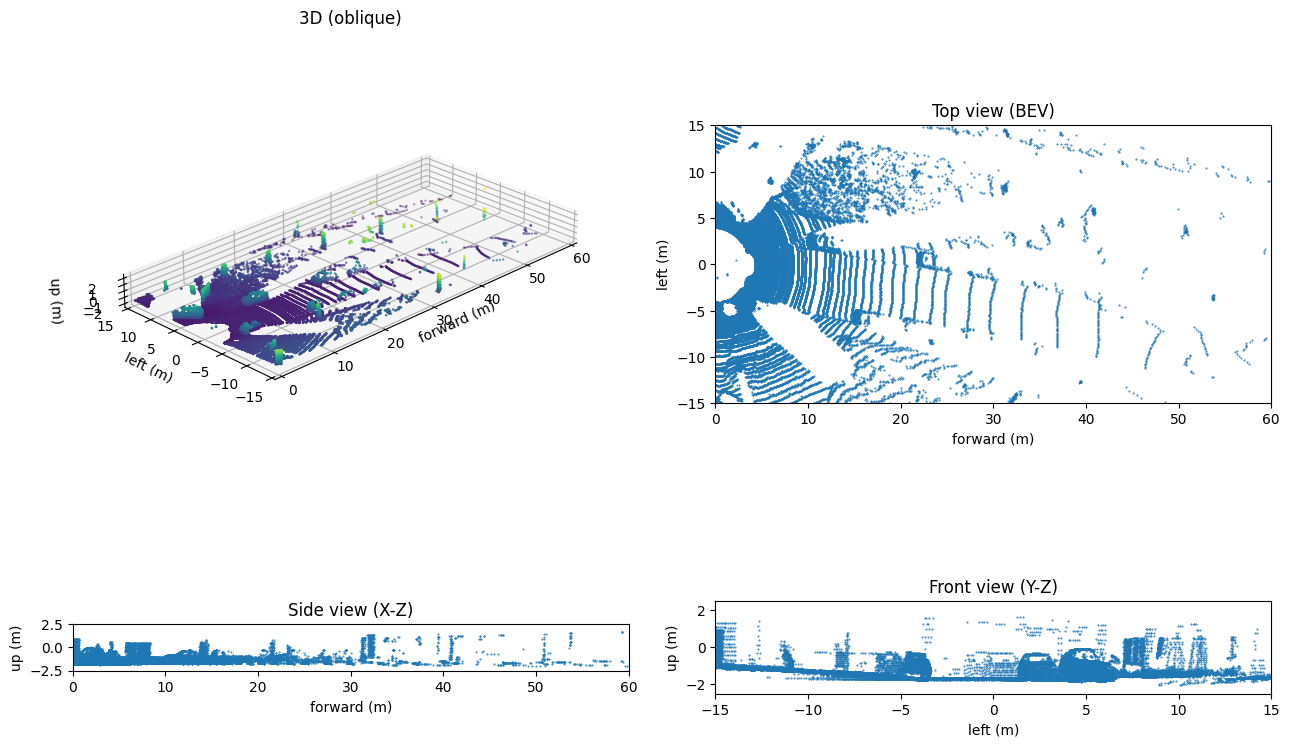

In [42]:
# ========== LiDAR 각도별 시각화 (forward/left/up 축) ==========
import numpy as np, matplotlib.pyplot as plt

cal_path = os.path.join(DATA_ROOT,"training","calib",   f"{SID}.txt")
bin_path = os.path.join(DATA_ROOT,"training","velodyne", f"{SID}.bin")
cal = read_calib(cal_path)
pts = load_velo(bin_path)[:,:3]
pts_cam = velo_to_cam_rect(pts, cal)

# 카메라→플롯 좌표 변환: X=fwd, Y=left, Z=up
X = pts_cam[:,2]; Y = -pts_cam[:,0]; Z = -pts_cam[:,1]

# ROI & 다운샘플
roi = ( (X>0) & (X<60) & (np.abs(Y)<15) & (Z>-2.5) & (Z<2.5) )
X,Y,Z = X[roi],Y[roi],Z[roi]
step = max(1, X.shape[0]//160_000); X,Y,Z = X[::step],Y[::step],Z[::step]

# 보기 원하는 3D 각도
ELEV, AZIM = 25, -135   # 원하는 값으로 바꿔서 재실행
fig = plt.figure(figsize=(13,9))

# (a) 3D 오블리크
ax = fig.add_subplot(2,2,1, projection='3d')
p = ax.scatter(X,Y,Z, c=Z, s=0.6)
ax.set_xlabel("forward (m)"); ax.set_ylabel("left (m)"); ax.set_zlabel("up (m)")
ax.set_xlim(0,60); ax.set_ylim(-15,15); ax.set_zlim(-2.5,2.5)
try: ax.set_box_aspect((60,30,5))
except: pass
ax.view_init(elev=ELEV, azim=AZIM)
ax.set_title("3D (oblique)")

# (b) BEV (탑뷰: X-Y)
ax = fig.add_subplot(2,2,2)
ax.scatter(X,Y,s=0.2); ax.set_aspect('equal','box')
ax.set_xlim(0,60); ax.set_ylim(-15,15)
ax.set_xlabel("forward (m)"); ax.set_ylabel("left (m)")
ax.set_title("Top view (BEV)")

# (c) Side (X-Z)
ax = fig.add_subplot(2,2,3)
ax.scatter(X,Z,s=0.2); ax.set_aspect('equal','box')
ax.set_xlim(0,60); ax.set_ylim(-2.5,2.5)
ax.set_xlabel("forward (m)"); ax.set_ylabel("up (m)")
ax.set_title("Side view (X-Z)")

# (d) Front (Y-Z)
ax = fig.add_subplot(2,2,4)
ax.scatter(Y,Z,s=0.2); ax.set_aspect('equal','box')
ax.set_xlim(-15,15); ax.set_ylim(-2.5,2.5)
ax.set_xlabel("left (m)"); ax.set_ylabel("up (m)")
ax.set_title("Front view (Y-Z)")

plt.tight_layout(); plt.show()


/tmp/ipykernel_2985215/234764970.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20')


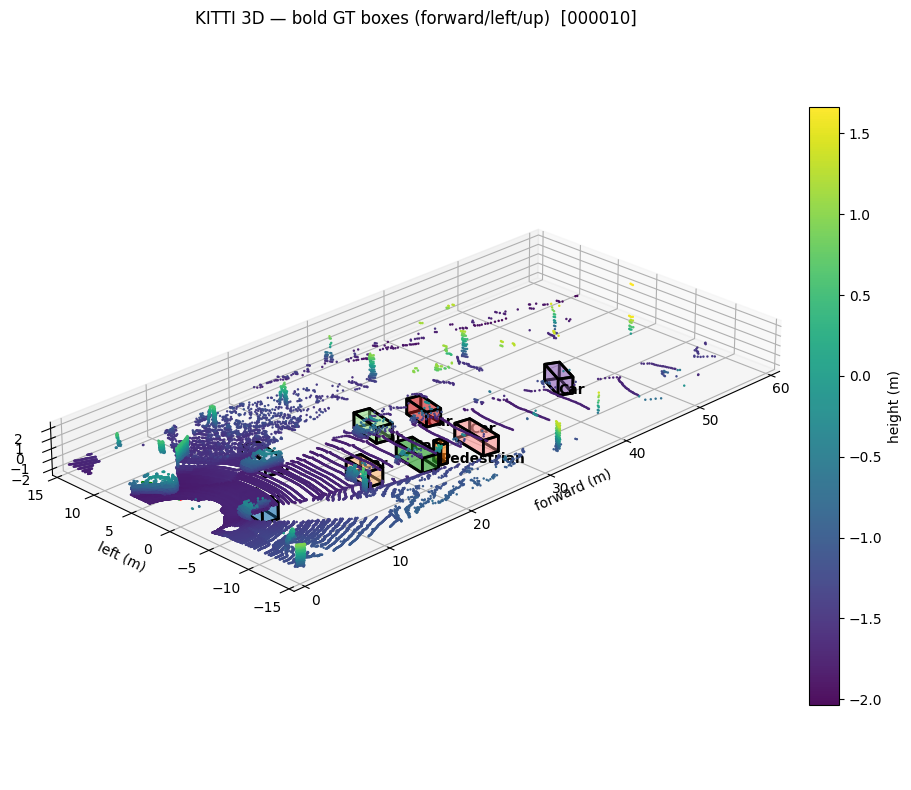

In [43]:
# ========== 굵은/진한 GT 3D 박스 + 예쁜 3D 뷰 ==========
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib import cm

lab_path = os.path.join(DATA_ROOT,"training","label_2",f"{SID}.txt")
objs = read_labels(lab_path)

def box3d_corners_cam(dims, loc, ry):
    h,w,l = dims
    x = np.array([ w/2,  w/2, -w/2, -w/2,  w/2,  w/2, -w/2, -w/2])
    y = np.array([   0,    0,    0,    0,  -h,  -h,   -h,   -h ])
    z = np.array([ l/2, -l/2, -l/2,  l/2,  l/2, -l/2, -l/2,  l/2])
    cy, sy = np.cos(ry), np.sin(ry)
    R = np.array([[ cy,0, sy],[0,1,0],[-sy,0,cy]])
    P = (R @ np.vstack([x,y,z])).T + np.array(loc)
    return P  # (8,3) camera coords

def box_faces(C):
    return [[C[0],C[1],C[2],C[3]],[C[4],C[5],C[6],C[7]],
            [C[0],C[1],C[5],C[4]],[C[1],C[2],C[6],C[5]],
            [C[2],C[3],C[7],C[6]],[C[3],C[0],C[4],C[7]]]

# 좌표 변환 유지
cmap = cm.get_cmap('tab20')

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

# 포인트 (높이 컬러)
sc = ax.scatter(X, Y, Z, c=Z, s=0.6, alpha=0.95)
cb = plt.colorbar(sc, pad=0.02, shrink=0.8); cb.set_label("height (m)")

# 굵고 진한 박스 (face=진하게, edge=더 두껍게)
for i,o in enumerate(objs):
    C_cam = box3d_corners_cam(o["dims"], o["loc"], o["ry"])
    C = np.column_stack([C_cam[:,2], -C_cam[:,0], -C_cam[:,1]])  # (X,Y,Z)
    faces = box_faces(C)
    col = cmap(i%20)
    poly = Poly3DCollection(faces, facecolors=[col]*6, edgecolors='k',
                            linewidths=2, alpha=0.4)  # ← 더 진하게/두껍게
    ax.add_collection3d(poly)
    ax.text(*(C[0]+[0,0,0.15]), o["type"], color='k', fontsize=10, weight='bold')

ax.set_xlabel("forward (m)"); ax.set_ylabel("left (m)"); ax.set_zlabel("up (m)")
ax.set_xlim(0,60); ax.set_ylim(-15,15); ax.set_zlim(-2.5,2.5)
try: ax.set_box_aspect((60,30,5))
except: pass
ax.view_init(elev=25, azim=-135)

# 원점 축
ax.quiver(0,0,0, 5,0,0, color='r'); ax.quiver(0,0,0, 0,5,0, color='g'); ax.quiver(0,0,0, 0,0,2, color='b')
plt.title(f"KITTI 3D — bold GT boxes (forward/left/up)  [{SID}]")
plt.tight_layout(); plt.show()


/tmp/ipykernel_2985215/4158946649.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20')


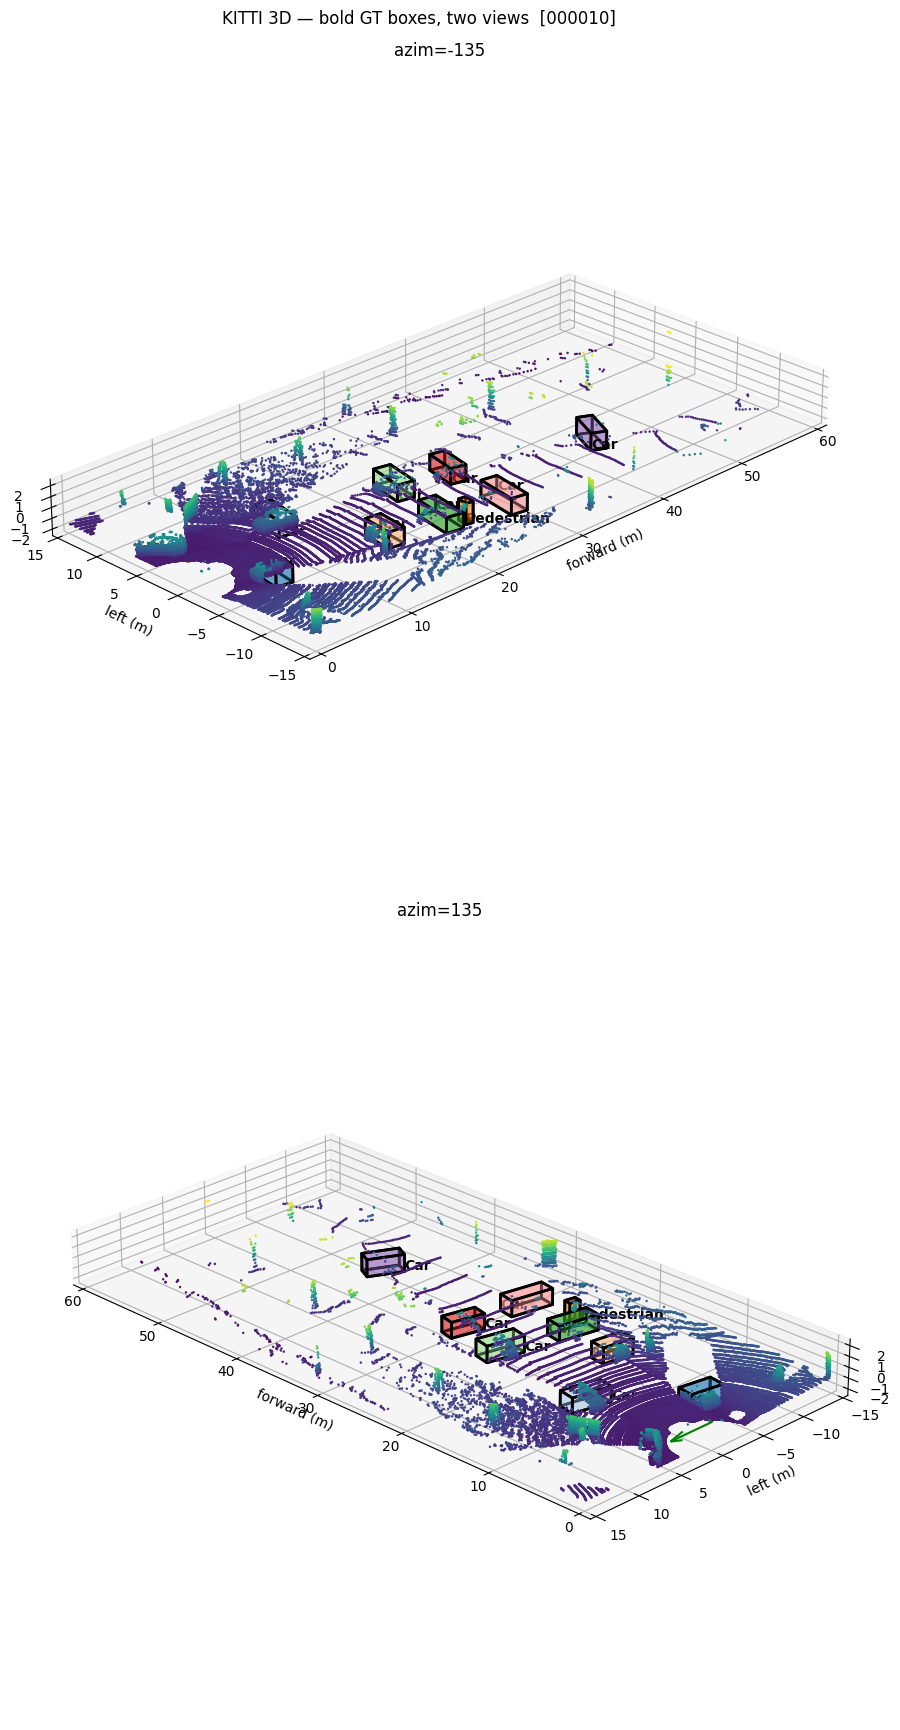

In [44]:
# ========== 굵은/진한 GT 3D 박스 + 두 각도 뷰 (컬러바 제거, 세로 크게) ==========
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib import cm

lab_path = os.path.join(DATA_ROOT,"training","label_2",f"{SID}.txt")
objs = read_labels(lab_path)

def box3d_corners_cam(dims, loc, ry):
    h,w,l = dims
    x = np.array([ w/2,  w/2, -w/2, -w/2,  w/2,  w/2, -w/2, -w/2])
    y = np.array([   0,    0,    0,    0,  -h,  -h,   -h,   -h ])
    z = np.array([ l/2, -l/2, -l/2,  l/2,  l/2, -l/2, -l/2,  l/2])
    cy, sy = np.cos(ry), np.sin(ry)
    R = np.array([[ cy,0, sy],[0,1,0],[-sy,0,cy]])
    P = (R @ np.vstack([x,y,z])).T + np.array(loc)
    return P

def box_faces(C):
    return [[C[0],C[1],C[2],C[3]],[C[4],C[5],C[6],C[7]],
            [C[0],C[1],C[5],C[4]],[C[1],C[2],C[6],C[5]],
            [C[2],C[3],C[7],C[6]],[C[3],C[0],C[4],C[7]]]

def plot_with_view(ax, X, Y, Z, objs, azim):
    cmap = cm.get_cmap('tab20')
    ax.scatter(X, Y, Z, c=Z, s=0.6, alpha=0.95)  # 컬러바 없이 표시만
    for i,o in enumerate(objs):
        C_cam = box3d_corners_cam(o["dims"], o["loc"], o["ry"])
        C = np.column_stack([C_cam[:,2], -C_cam[:,0], -C_cam[:,1]])
        faces = box_faces(C)
        col = cmap(i%20)
        poly = Poly3DCollection(faces, facecolors=[col]*6, edgecolors='k',
                                linewidths=2, alpha=0.4)
        ax.add_collection3d(poly)
        ax.text(*(C[0]+[0,0,0.15]), o["type"], color='k', fontsize=10, weight='bold')

    ax.set_xlabel("forward (m)"); ax.set_ylabel("left (m)"); ax.set_zlabel("up (m)")
    ax.set_xlim(0,60); ax.set_ylim(-15,15); ax.set_zlim(-2.5,2.5)
    try: ax.set_box_aspect((60,30,5))
    except: pass
    ax.view_init(elev=25, azim=azim)
    ax.quiver(0,0,0, 5,0,0, color='r')
    ax.quiver(0,0,0, 0,5,0, color='g')
    ax.quiver(0,0,0, 0,0,2, color='b')
    ax.set_title(f"azim={azim}")

# 세로로 크게: (너비, 높이)
fig = plt.figure(figsize=(10, 18))

ax1 = fig.add_subplot(211, projection='3d')
plot_with_view(ax1, X, Y, Z, objs, azim=-135)

ax2 = fig.add_subplot(212, projection='3d')
plot_with_view(ax2, X, Y, Z, objs, azim=135)

# 여백/간격 조절 (세로 간격 작게)
plt.subplots_adjust(left=0.06, right=0.98, top=0.95, bottom=0.03, hspace=0.08)

plt.suptitle(f"KITTI 3D — bold GT boxes, two views  [{SID}]")
plt.show()


/tmp/ipykernel_2985215/1312039355.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmapp = cm.get_cmap('turbo') if hasattr(cm, 'turbo') else cm.get_cmap('jet')


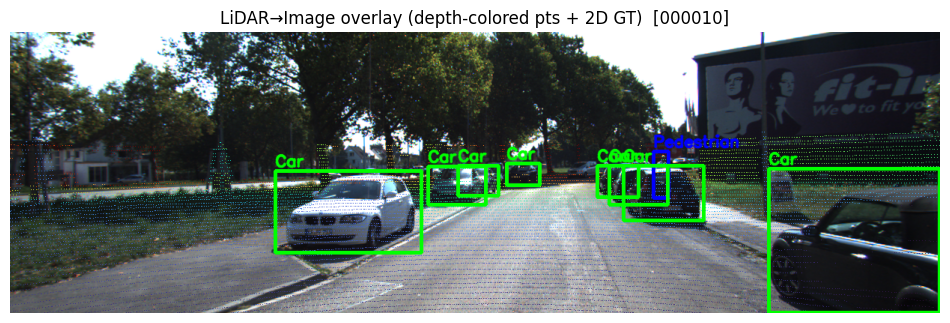

In [45]:
# ========== LiDAR + 이미지 합성(오버레이) ==========
from matplotlib import cm

img_path = os.path.join(DATA_ROOT,"training","image_2",f"{SID}.png")
cal_path = os.path.join(DATA_ROOT,"training","calib",   f"{SID}.txt")
lab_path = os.path.join(DATA_ROOT,"training","label_2", f"{SID}.txt")

img  = cv2.imread(img_path);  H,W = img.shape[:2]
cal  = read_calib(cal_path)
pts  = load_velo(bin_path)[:,:3]

# 투영
uvz, idx = project_velo_to_img(pts, cal)
u, v, z = uvz[:,0], uvz[:,1], uvz[:,2]
mask = (u>=0)&(u<W)&(v>=0)&(v<H)
u = u[mask]; v = v[mask]; z = z[mask]

# 깊이 컬러(선명한 turbo/jet 계열)
cmapp = cm.get_cmap('turbo') if hasattr(cm, 'turbo') else cm.get_cmap('jet')
z_clip = np.clip(z, 0, 60)
zn = (z_clip - z_clip.min()) / max(1e-6, (z_clip.max()-z_clip.min()))
colors = (cmapp(zn)[:,:3]*255).astype(np.uint8)  # RGB

overlay = img.copy()
# 점 크기/밀도 조절
for (uu,vv), (r,g,b) in zip(np.column_stack([u.astype(int), v.astype(int)]), colors):
    overlay[vv, uu] = (b,g,r)   # BGR

# 2D 라벨(굵고 선명)
objs = read_labels(lab_path)
for o in objs:
    l,t,r,b = map(int,o["bbox"])
    col = (0,255,0) if o["type"]=="Car" else (255,0,0) if o["type"]=="Pedestrian" else (0,200,255)
    cv2.rectangle(overlay,(l,t),(r,b),col,3)
    cv2.putText(overlay, o["type"], (l, max(10,t-6)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, col, 2, cv2.LINE_AA)

plt.figure(figsize=(12,5))
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)); plt.axis('off')
plt.title(f"LiDAR→Image overlay (depth-colored pts + 2D GT)  [{SID}]")
plt.show()


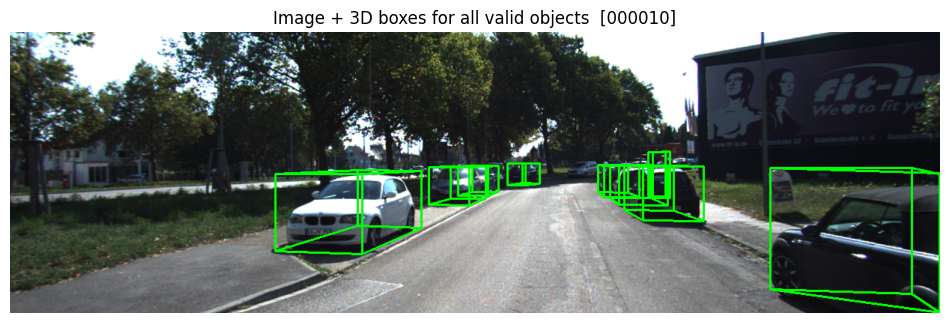

In [50]:
# === Image + projected 3D boxes for ALL objects (fallback 2D if no 3D) ===
import os, cv2, numpy as np, matplotlib.pyplot as plt

DATA_ROOT = "/home/jinjinjara1022/AutonomousDriving/datasets/kitti_object"
SID = "000010"  # 원하는 프레임

img_path = os.path.join(DATA_ROOT,"training","image_2",f"{SID}.png")
lab_path = os.path.join(DATA_ROOT,"training","label_2",f"{SID}.txt")
cal_path = os.path.join(DATA_ROOT,"training","calib",  f"{SID}.txt")

def read_calib(path):
    D={}
    with open(path) as f:
        for ln in f:
            if ":" not in ln: continue
            k,v = ln.split(":",1); a = np.fromstring(v, sep=" "); k = k.strip()
            if k in ("P2","P0","P1","P3"): D[k] = a.reshape(3,4)
    assert "P2" in D, "P2 not found in calib"
    return D

def read_labels(path):
    objs=[]
    with open(path) as f:
        for ln in f:
            a = ln.split()
            if not a or a[0].lower()=="dontcare": continue
            h,w,l = map(float, a[8:11])
            x,y,z = map(float, a[11:14])
            ry = float(a[14])
            l2,t2,r2,b2 = map(float, a[4:8])
            objs.append({"type":a[0], "bbox":[l2,t2,r2,b2], "dims":[h,w,l], "loc":[x,y,z], "ry":ry})
    return objs

def has_valid_3d(o):
    h,w,l = o["dims"]; x,y,z = o["loc"]
    arr = np.array([h,w,l,x,y,z], dtype=float)
    return np.all(np.isfinite(arr)) and (h>0 and w>0 and l>0 and z>0)

def box3d_corners_cam(dims, loc, ry):
    # KITTI: dims = [h, w, l], loc = [x, y, z] (camera coords, bottom center)
    h, w, l = dims

    # 객체 로컬 좌표계 코너 (x: length, z: width, y: 0→-h)
    x_c = np.array([ l/2,  l/2, -l/2, -l/2,  l/2,  l/2, -l/2, -l/2 ])
    y_c = np.array([   0,    0,    0,    0,  -h,  -h,   -h,   -h   ])
    z_c = np.array([ w/2, -w/2, -w/2,  w/2,  w/2, -w/2, -w/2,  w/2 ])

    cy, sy = np.cos(ry), np.sin(ry)
    R = np.array([[  cy, 0,  sy],
                  [   0, 1,   0],
                  [ -sy, 0,  cy]])

    corners = (R @ np.vstack([x_c, y_c, z_c])).T + np.array(loc).reshape(1,3)
    return corners  # (8,3) in rectified camera coords


EDGES = [(0,1),(1,2),(2,3),(3,0),
         (4,5),(5,6),(6,7),(7,4),
         (0,4),(1,5),(2,6),(3,7)]

img = cv2.imread(img_path); H,W = img.shape[:2]
cal = read_calib(cal_path)
objs = read_labels(lab_path)

canvas = img.copy()
n3d, n2d = 0, 0
for o in objs:
    if has_valid_3d(o):
        C = box3d_corners_cam(o["dims"], o["loc"], o["ry"])   # (8,3) in cam
        C_h = np.hstack([C, np.ones((8,1))])
        uvw = (cal["P2"] @ C_h.T).T
        if np.any(uvw[:,2] <= 0):  # 카메라 뒤면 스킵
            continue
        pts = np.column_stack([uvw[:,0]/uvw[:,2], uvw[:,1]/uvw[:,2]]).astype(int)
        col = (0,255,0)  # green
        for a,b in EDGES:
            pa = (int(np.clip(pts[a,0],0,W-1)), int(np.clip(pts[a,1],0,H-1)))
            pb = (int(np.clip(pts[b,0],0,W-1)), int(np.clip(pts[b,1],0,H-1)))
            cv2.line(canvas, pa, pb, col, thickness=2)
        n3d += 1
    else:
        # 3D가 없으면 2D 박스로만 얇게 표시 (원하면 이 블록 지워도 됨)
        l,t,r,b = map(int, o["bbox"])
        cv2.rectangle(canvas, (l,t), (r,b), (0,200,255), 2)  # orange, thin
        n2d += 1

plt.figure(figsize=(12,5))
plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)); plt.axis('off')
plt.title(f"Image + 3D boxes for all valid objects  [{SID}]")
plt.show()